In [1]:
import numpy as np 
import pandas as pd 
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

Using TensorFlow backend.


In [2]:
os.listdir(path='.')
listOfFile = os.listdir("./color")
x=len(listOfFile)
for i in range(0,x):
    print(listOfFile[i])

Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___healthy
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites_Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [3]:
onlyfiles=[]
x=len(listOfFile)
for i in range(0,x):
    folder="./color/"+listOfFile[i]
    print
    onlyfiles2 = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for t in range(0, len(onlyfiles2)):
        onlyfiles.append(folder+"/"+onlyfiles2[t])
print("Working with {0} images".format(len(onlyfiles)))

Working with 18160 images


In [11]:
train_files = []
y_train = []
i=0
for _file in onlyfiles:
    train_files.append(_file)
    r1 = re.search(r".+/", _file)
    #label_in_file = _file.find("_")
    y_train.append(r1.group())
    i=i+1
    
print("Files in train_files: %d" % len(train_files))

image_width = 256
image_height = 256
ratio = 4
image_width = int(image_width / ratio)
image_height = int(image_height / ratio)

channels = 3
nb_classes = 1

dataset = np.ndarray(shape=(len(train_files), channels, image_height, image_width),
                     dtype=np.float32)

i = 0
for _file in train_files:
    img = load_img(_file) 
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)  
    x = x.reshape((3, 64, 64))
    # Normalize
    #x = (x - 128.0) / 128.0
    dataset[i] = x
    i += 1
    if i % 10000 == 0:
        print("%d images to array" % i)
print("All images to array!")
#save('dataset.npy', dataset)

Files in train_files: 18160
10000 images to array
All images to array!


./color/Tomato___Bacterial_spot/


# splitting and normalization

In [14]:
#Splitting 
X_train, X_test, y_train, y_test = train_test_split(dataset, y_train, test_size=0.2, random_state=33)
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)

x train:  (14528, 3, 64, 64)
x test:  (3632, 3, 64, 64)


In [16]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train = pd.Categorical(y_train).codes
y_test = pd.Categorical(y_test).codes
print(y_train[6])
#print(y_train[5])

7


In [17]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
#cnn için gerekli one hot encoding
#y_train=np.array(y_train)
#y_test=np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#y_train = y_train / 255.0
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (14528, 3, 64, 64)
X_test shape:  (3632, 3, 64, 64)


In [18]:
#reshape data to fit model
x_train = X_train.reshape(14528,64,64,3)
x_test = X_test.reshape(3632,64,64,3)
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)

x train:  (14528, 64, 64, 3)
x test:  (3632, 64, 64, 3)


In [19]:
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14528, 64, 64, 3)
x test:  (3632, 64, 64, 3)
y train:  (14528, 10)
y test:  (3632, 10)


# cnn model

In [20]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(80, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))  #10 y'deki class sayısı

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [22]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
epochs = 25
batch_size = 125

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0.5,  
        zoom_range = 0.5,
        width_shift_range=0.5, 
        height_shift_range=0.5,  
        horizontal_flip=False,
        vertical_flip=False)  

datagen.fit(x_train)

In [25]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
116/116 [==============================] - 27s 232ms/step - loss: 1.9790 - acc: 0.3046 - val_loss: 1.9351 - val_acc: 0.3150
Epoch 2/25
116/116 [==============================] - 23s 196ms/step - loss: 1.8331 - acc: 0.3642 - val_loss: 1.7067 - val_acc: 0.4436
Epoch 3/25
116/116 [==============================] - 22s 191ms/step - loss: 1.7100 - acc: 0.4188 - val_loss: 1.5354 - val_acc: 0.4681
Epoch 4/25
116/116 [==============================] - 21s 184ms/step - loss: 1.6008 - acc: 0.4551 - val_loss: 1.4297 - val_acc: 0.4915
Epoch 5/25
116/116 [==============================] - 21s 185ms/step - loss: 1.5028 - acc: 0.4947 - val_loss: 1.3518 - val_acc: 0.5284
Epoch 6/25
116/116 [==============================] - 22s 187ms/step - loss: 1.4469 - acc: 0.5044 - val_loss: 1.2077 - val_acc: 0.6005
Epoch 7/25
116/116 [==============================] - 21s 185ms/step - loss: 1.3908 - acc: 0.5285 - val_loss: 1.1930 - val_acc: 0.5834
Epoch 8

# plotting

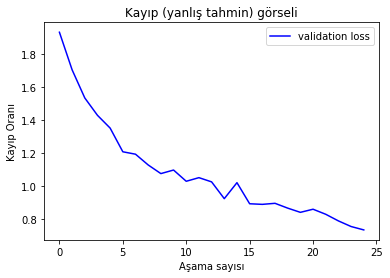

In [26]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Kayıp (yanlış tahmin) görseli")
plt.xlabel("Aşama sayısı")
plt.ylabel("Kayıp Oranı")
plt.legend()
plt.show()

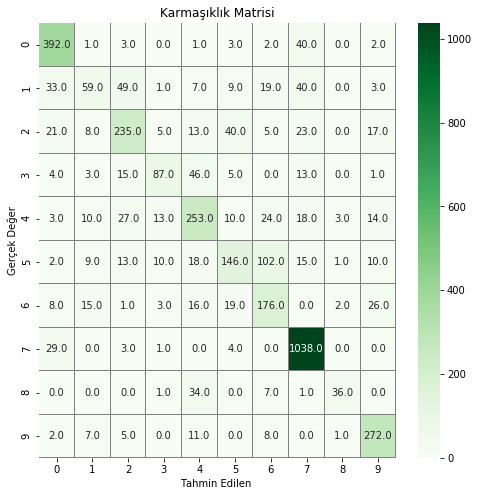

In [27]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Tahmin Edilen ")
plt.ylabel("Gerçek Değer")
plt.title("Karmaşıklık Matrisi")
plt.show()

# model2

In [28]:
os.listdir(path='.')
listOfFile = os.listdir("./color2")
x=len(listOfFile)
for i in range(0,x):
    print(listOfFile[i])

Apple_Frogeye_Spot
Apple___Apple_scab
Apple___Cedar_apple_rust
Apple___healthy


In [31]:
onlyfiles=[]
x=len(listOfFile)
for i in range(0,x):
    folder="./color2/"+listOfFile[i]
    print
    onlyfiles2 = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for t in range(0, len(onlyfiles2)):
        onlyfiles.append(folder+"/"+onlyfiles2[t])
print("Working with {0} images".format(len(onlyfiles)))

Working with 3171 images


In [32]:
train_files = []
y_train = []
i=0
for _file in onlyfiles:
    train_files.append(_file)
    r1 = re.search(r".+/", _file)
    #label_in_file = _file.find("_")
    y_train.append(r1.group())
    i=i+1
    
print("Files in train_files: %d" % len(train_files))

image_width = 256
image_height = 256
ratio = 4
image_width = int(image_width / ratio)
image_height = int(image_height / ratio)

channels = 3
nb_classes = 1

dataset = np.ndarray(shape=(len(train_files), channels, image_height, image_width),
                     dtype=np.float32)

i = 0
for _file in train_files:
    img = load_img(_file) 
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)  
    x = x.reshape((3, 64, 64))
    # Normalize
    #x = (x - 128.0) / 128.0
    dataset[i] = x
    i += 1
    if i % 1000 == 0:
        print("%d images to array" % i)
print("All images to array!")

Files in train_files: 3171
1000 images to array
2000 images to array
3000 images to array
All images to array!


# model2 splitting and normalization

In [33]:
#Splitting 
X_train, X_test, y_train, y_test = train_test_split(dataset, y_train, test_size=0.2, random_state=33)
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)

x train:  (2536, 3, 64, 64)
x test:  (635, 3, 64, 64)


In [34]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train = pd.Categorical(y_train).codes
y_test = pd.Categorical(y_test).codes
print(y_train[6])
#print(y_train[5])

2


In [35]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
#cnn için gerekli one hot encoding
#y_train=np.array(y_train)
#y_test=np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#y_train = y_train / 255.0
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (2536, 3, 64, 64)
X_test shape:  (635, 3, 64, 64)


In [36]:
#reshape data to fit model
x_train = X_train.reshape(2536,64,64,3)
x_test = X_test.reshape(635,64,64,3)
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)

x train:  (2536, 64, 64, 3)
x test:  (635, 64, 64, 3)


In [37]:
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (2536, 64, 64, 3)
x test:  (635, 64, 64, 3)
y train:  (2536, 4)
y test:  (635, 4)


# cnn model 2(daha az örnek ile)

In [44]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(80, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))  #4 y'deki class sayısı

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 55
batch_size = 250

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0.5,  
        zoom_range = 0.5,
        width_shift_range=0.5, 
        height_shift_range=0.5,  
        horizontal_flip=False,
        vertical_flip=False)  

datagen.fit(x_train)

In [45]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/55
10/10 [==============================] - 4s 448ms/step - loss: 1.2612 - acc: 0.4812 - val_loss: 1.1963 - val_acc: 0.5150
Epoch 2/55
10/10 [==============================] - 3s 294ms/step - loss: 1.2001 - acc: 0.5201 - val_loss: 1.1782 - val_acc: 0.5150
Epoch 3/55
10/10 [==============================] - 3s 338ms/step - loss: 1.1640 - acc: 0.5246 - val_loss: 1.1491 - val_acc: 0.5150
Epoch 4/55
10/10 [==============================] - 3s 336ms/step - loss: 1.1516 - acc: 0.5125 - val_loss: 1.1083 - val_acc: 0.5150
Epoch 5/55
10/10 [==============================] - 3s 337ms/step - loss: 1.1236 - acc: 0.5025 - val_loss: 1.0578 - val_acc: 0.5134
Epoch 6/55
10/10 [==============================] - 3s 336ms/step - loss: 1.0514 - acc: 0.5259 - val_loss: 0.9994 - val_acc: 0.5827
Epoch 7/55
10/10 [==============================] - 3s 339ms/step - loss: 1.0217 - acc: 0.5269 - val_loss: 0.9542 - val_acc: 0.6031
Epoch 8/55
10/10 [==============================] - 3s 342ms/step - loss: 0.

# plotting

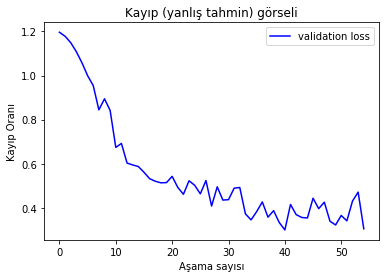

In [46]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Kayıp (yanlış tahmin) görseli")
plt.xlabel("Aşama sayısı")
plt.ylabel("Kayıp Oranı")
plt.legend()
plt.show()

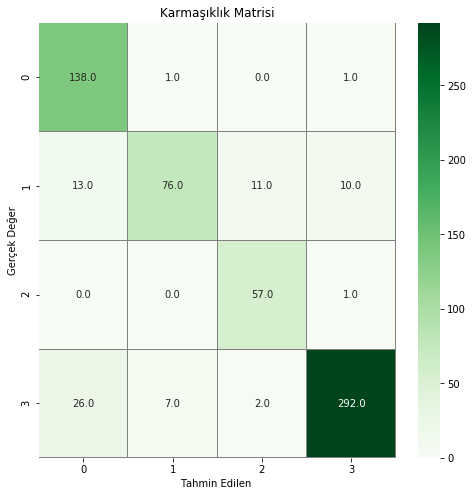

In [47]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Tahmin Edilen ")
plt.ylabel("Gerçek Değer")
plt.title("Karmaşıklık Matrisi")
plt.show()